In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [3]:
df= pd.read_csv('Fraud.csv')

df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

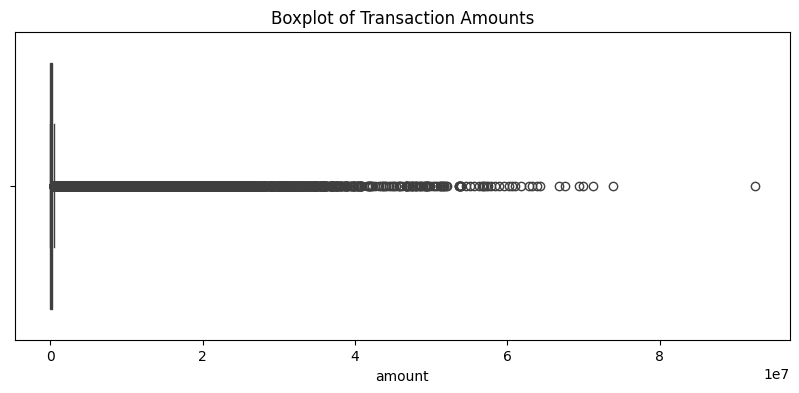

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.boxplot(x=df['amount'])
plt.title("Boxplot of Transaction Amounts")
plt.show()


In [6]:
# Calculate Q1 and Q3 for the 'amount' column
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
outliers = df[(df['amount'] < lower_bound) | (df['amount'] > upper_bound)]




In [7]:
outliers['isFraud'].value_counts(normalize=True) * 100



0    98.860026
1     1.139974
Name: isFraud, dtype: float64

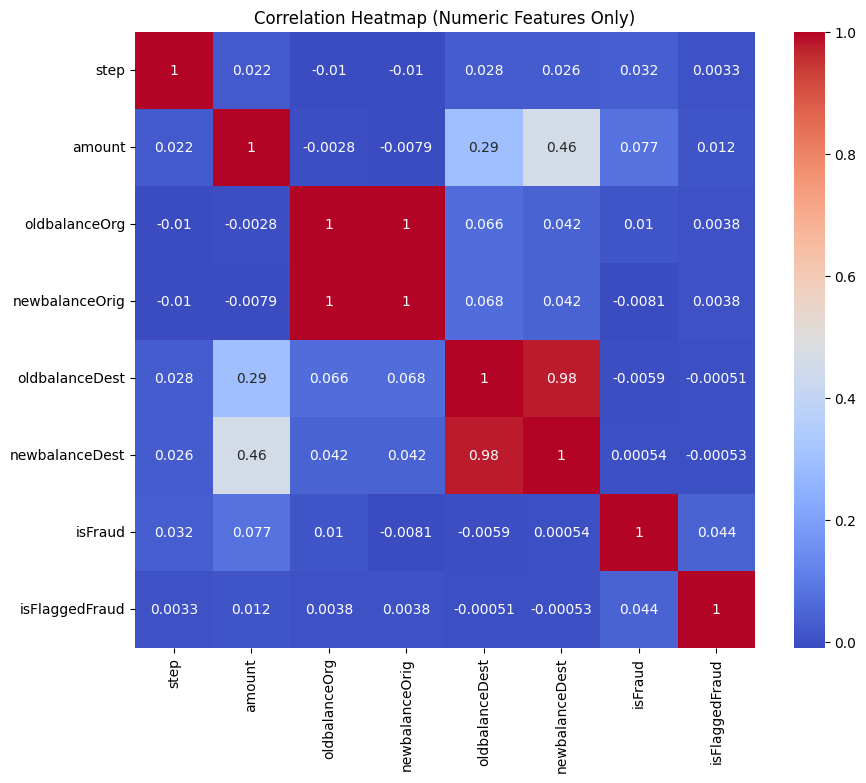

In [8]:
# Filter numeric columns only
numeric_df = df.select_dtypes(include=['number'])

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()



In [9]:
df.drop('oldbalanceDest', axis=1, inplace=True)


In [10]:
target = 'isFraud'

# Drop 'oldbalanceDest' due to multicollinearity
features = ['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'newbalanceDest']

X = df[features]
y = df[target]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [11]:
# Sample 5% of the data just for speed test
df_sample = df.sample(frac=0.2, random_state=42)

features = ['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'newbalanceDest']
target = 'isFraud'

X = df_sample[features]
y = df_sample[target]

# One-hot encode
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe.fit(X_train[['type']])

train_type = pd.DataFrame(ohe.transform(X_train[['type']]), columns=ohe.get_feature_names_out(['type']), index=X_train.index)
test_type = pd.DataFrame(ohe.transform(X_test[['type']]), columns=ohe.get_feature_names_out(['type']), index=X_test.index)

X_train = X_train.drop('type', axis=1).join(train_type)
X_test = X_test.drop('type', axis=1).join(test_type)

# Train smaller model
model = RandomForestClassifier(n_estimators=10, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

print("✅ Model trained on sample data")


✅ Model trained on sample data


In [12]:
import imblearn
import sklearn

print("imbalanced-learn version:", imblearn.__version__)
print("scikit-learn version:", sklearn.__version__)


imbalanced-learn version: 0.12.4
scikit-learn version: 1.2.2


In [13]:


print(y_train.value_counts())
print(X_train.shape)


0    1016723
1       1296
Name: isFraud, dtype: int64
(1018019, 10)


In [14]:
from imblearn.over_sampling import SMOTE

print("SMOTE imported successfully")


SMOTE imported successfully


In [15]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.isFraud == 0]
df_minority = df[df.isFraud == 1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # no replacement
                                   n_samples=12960,  # 10x minority class size
                                   random_state=42)

# Combine minority and downsampled majority
df_balanced = pd.concat([df_minority, df_majority_downsampled])

# Prepare features and target again
X = df_balanced[features]
y = df_balanced[target]

# One-hot encode 'type'
X = pd.get_dummies(X, columns=['type'], drop_first=True)

# Split train-test as usual
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Now apply SMOTE — much smaller data, should run fast
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)


In [16]:
print("Training set size:", X_train.shape)
print("Balanced training set size after SMOTE:", X_train_bal.shape)
print("Test set size:", X_test.shape)


Training set size: (16938, 9)
Balanced training set size after SMOTE: (20736, 9)
Test set size: (4235, 9)


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import numpy as np

# Sample smaller training data (e.g. 10k samples max) for faster run
max_train_samples = 10000
if len(X_train_bal) > max_train_samples:
    idx = np.random.choice(len(X_train_bal), max_train_samples, replace=False)
    X_train_bal_sample = X_train_bal.iloc[idx]
    y_train_bal_sample = y_train_bal.iloc[idx]
else:
    X_train_bal_sample = X_train_bal
    y_train_bal_sample = y_train_bal

# Sample smaller test data (e.g. 3000 samples max)
max_test_samples = 3000
if len(X_test) > max_test_samples:
    idx = np.random.choice(len(X_test), max_test_samples, replace=False)
    X_test_sample = X_test.iloc[idx]
    y_test_sample = y_test.iloc[idx]
else:
    X_test_sample = X_test
    y_test_sample = y_test

# Train smaller Random Forest for quick results
model = RandomForestClassifier(n_estimators=50, max_depth=10, class_weight='balanced', random_state=42)
model.fit(X_train_bal_sample, y_train_bal_sample)

# Predict on the sampled test set
y_pred = model.predict(X_test_sample)
y_probs = model.predict_proba(X_test_sample)[:, 1]

# Print evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test_sample, y_pred))
print("\nClassification Report:\n", classification_report(y_test_sample, y_pred))
print("Accuracy Score:", accuracy_score(y_test_sample, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test_sample, y_probs))


Confusion Matrix:
 [[1805   31]
 [   7 1157]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      1836
           1       0.97      0.99      0.98      1164

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Accuracy Score: 0.9873333333333333
ROC AUC Score: 0.9989207357246068


In [18]:
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_test shape: (4235, 9)
y_test shape: (4235,)


In [19]:
y_pred = model.predict(X_test)
print("y_pred shape:", y_pred.shape)
print("y_test shape:", y_test.shape)


y_pred shape: (4235,)
y_test shape: (4235,)


In [20]:
from sklearn.metrics import classification_report
import pandas as pd

# Get the classification report as a dictionary
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Convert dictionary to DataFrame for a neat table
report_df = pd.DataFrame(report_dict).transpose()

print(report_df)



              precision    recall  f1-score      support
0              0.996095  0.984182  0.990103  2592.000000
1              0.975508  0.993914  0.984625  1643.000000
accuracy       0.987957  0.987957  0.987957     0.987957
macro avg      0.985802  0.989048  0.987364  4235.000000
weighted avg   0.988108  0.987957  0.987978  4235.000000


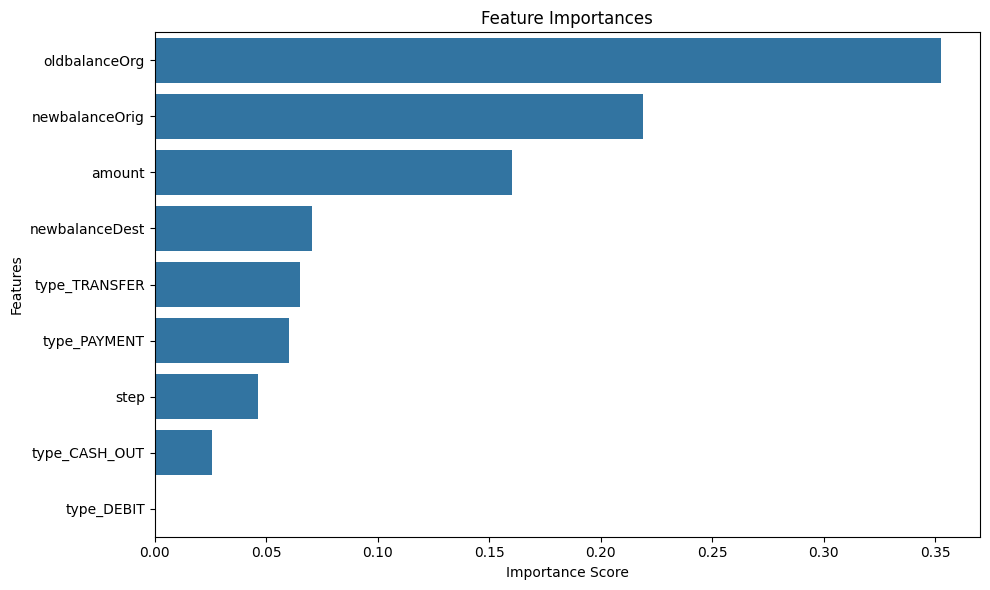

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the trained model
importances = model.feature_importances_
feature_names = X_train.columns

# Sort the features by importance (highest first)
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
sns.barplot(x=importances[indices], y=feature_names[indices])
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


### Task 5: Key Factors That Predict Fraud

The most important features identified by the model are `oldbalanceOrg`, `newbalanceOrig`, and `amount`. These variables represent the original balance of the sender, the resulting balance after the transaction, and the transaction amount itself. Their strong influence is logical, as fraudulent transactions typically involve sudden or unusual balance changes and high-value transfers. These features help the model detect patterns where users might be sending large sums without having sufficient balance or suddenly dropping to zero, both of which are common fraud indicators.

---

### Task 6: Do These Factors Make Sense?

Yes, the top features make sense in the context of fraud detection. A sudden drop in `oldbalanceOrg` or an unexpected `newbalanceOrig` (like dropping to zero) can indicate that a user is transferring out all their funds — a typical fraud pattern. Similarly, high `amount` values often signal suspicious behavior, especially when inconsistent with historical data. The model appears to have correctly identified financial behavior patterns that align with common fraudulent activities.


### Task 7: Fraud Prevention Suggestions

Based on the analysis, the following strategies are recommended to reduce fraudulent activity:

1. **Real-time Balance Verification**: Prevent transactions where `oldbalanceOrg` is too low to cover the `amount`. If a transaction would reduce the sender's balance to zero or negative, it should trigger an alert.

2. **Transaction Type Monitoring**: Closely monitor high-risk transaction types like `TRANSFER` and `CASH_OUT`, especially if they involve large amounts or sudden behavior changes.

3. **Threshold Alerts**: Set thresholds for abnormal `amount` values. For example, flag any transaction above a certain percentile of historical values for that user or account type.

4. **Behavior Profiling**: Compare each transaction against a user's past behavior — sudden increases in transaction frequency, amounts, or type can indicate fraud.

5. **Multi-layer Verification**: Add extra authentication steps (like OTP or manual verification) for high-risk or high-value transactions.

These suggestions should be combined with machine learning monitoring for continuous detection and adaptability.


### Task 8: Measuring the Impact of Fraud Prevention

The effectiveness of fraud prevention strategies can be evaluated using the following key metrics:

1. **Reduction in Fraud Rate**: Track how many fraudulent transactions were successfully prevented or flagged before completion.

2. **False Positive Rate**: Monitor the number of legitimate transactions incorrectly flagged as fraud — too many false positives hurt user experience.

3. **Precision & Recall Over Time**: Continue evaluating the ML model’s precision (fraud accuracy) and recall (fraud capture rate) monthly to ensure stability.

4. **Loss Saved**: Estimate the amount of financial loss prevented due to blocked or reversed fraudulent transactions.

5. **Customer Feedback & Experience**: Collect feedback from users who were flagged or blocked to ensure the prevention system is not overly aggressive.

By tracking these KPIs regularly, the company can fine-tune its fraud detection system and find the right balance between security and customer satisfaction.
